# Imports


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import os

In [2]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth, association_rules

# Load data

In [3]:
df = pd.read_csv("data/clicks_sample.csv")

In [4]:
full_df = pd.read_csv("data/full_df.csv.gz", compression="gzip")

In [5]:
full_df.click_timestamp = full_df.click_timestamp.astype(int)

In [6]:
full_df.session_start = full_df.session_start.astype(int)

In [7]:
full_df['session_start_time'] = pd.to_datetime(full_df.session_start, unit="ms")

In [8]:
date = pd.to_datetime(np.min(full_df.session_start), unit="ms")
hour = np.timedelta64(1, 'h')
full_df['hour'] = full_df['session_start_time'].apply(
    lambda x: (date - x) / hour)

In [9]:
full_df['hour'] = np.abs(np.round(full_df['hour']))

In [10]:
full_df = full_df.sort_values("hour")

In [11]:
articles_per_session = []
for session_id, data in df.groupby("session_id"):
    articles_per_session += [list(enumerate(data["click_article_id"].values))]

In [12]:
x = articles_per_session

In [13]:
x[:10]

[[(0, 157541), (1, 68866)],
 [(0, 235840), (1, 96663)],
 [(0, 119592), (1, 30970)],
 [(0, 236065), (1, 236294)],
 [(0, 48915), (1, 44488)],
 [(0, 168868), (1, 207122), (2, 286413)],
 [(0, 202436), (1, 288431)],
 [(0, 235840), (1, 284847)],
 [(0, 332114), (1, 284847), (2, 114161)],
 [(0, 284346), (1, 285412)]]

# Create frequent patterns

In [16]:
def get_article_list(df):
    articles_per_session = []
    for session_id, data in df.groupby("session_id"):
        articles_per_session += [list(enumerate(data["click_article_id"].values))]
    return articles_per_session

In [17]:
def get_frequent_ar(te, x, min_sessions):
    te_ary = te.transform(x)
    data = pd.DataFrame(te_ary, columns=te.columns_)
    frequent_itemsets = fpgrowth(data, min_support=min_sessions/len(x), use_colnames=True)
    ar = association_rules(frequent_itemsets, metric="support", min_threshold=min_sessions/len(x))
    ar["n"] = ar["support"] * len(x)
    return ar

In [18]:
def get_frequent(te, x, min_sessions):
    te_ary = te.transform(x)
    data = pd.DataFrame(te_ary, columns=te.columns_)
    frequent_itemsets = fpgrowth(data, min_support=min_sessions/len(x), use_colnames=True)
    frequent_itemsets["n"] = frequent_itemsets["support"] * len(x)
    return frequent_itemsets

In [19]:
xx = get_article_list(full_df)

In [20]:
te = TransactionEncoder()
te.fit(xx)

TransactionEncoder()

In [22]:
data = full_df.loc[full_df.hour == 42]
freq = get_frequent_ar(te, get_article_list(data), 10)
#freq = freq.loc[(freq.antecedents == frozenset({(0, 199198)})) & (freq.consequents == frozenset({(1, 272143)}))]

In [277]:
def get_by_pos(freq, item):
    freq['items'] = pd.Series(freq["antecedents"].apply(lambda x: list(map(lambda y: y[1], x))))
    freq['pos'] = pd.Series(freq["antecedents"].apply(lambda x: list(map(lambda y: y[0], x))))
    freq['items'].apply(lambda x: x)
    freq["ist"] = freq["items"].apply(lambda x: np.where(np.array(x) == item)[0])
    ddd = freq.loc[freq.ist.apply(lambda x: len(x))>0, ["n","pos", "ist"]]
    ddd["xx"] = freq.loc[freq.ist.apply(lambda x: len(x))>0, ["pos", "ist", "n"]].apply(lambda x: x.iloc[0][x.iloc[1][0]], axis=1)
    if "xx" in list(ddd.columns):
        return list(ddd.groupby("xx").sum().n)
    else: 
        return [0]

In [278]:
def get_pos_by_hour(te, hour, min_sessions, item):
    print(hour)
    data = full_df.loc[full_df.hour == hour]
    freq = get_frequent_ar(te, get_article_list(data), min_sessions)
    return get_by_pos(freq, item)

In [282]:
li = [get_pos_by_hour(te,hour,10, 162655) for hour in range(37, 43)]

37
38
39
40
41
42


In [283]:
li

[[20.0, 29.0, 11.0],
 [491.0, 627.0, 174.0, 20.0],
 [763.0, 621.0, 225.0, 11.0],
 [1113.0, 1219.0, 581.0, 113.0],
 [1407.0, 1076.0, 543.0, 80.0, 13.0],
 [2056.0, 773.0, 309.0, 24.0]]

(0.0, 1.0)

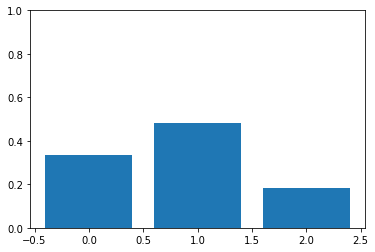

In [284]:
plt.bar(list(range(int(len(li[0])))), np.array(li[0])/sum(li[0]))
plt.ylim([0,1])

(0.0, 1.0)

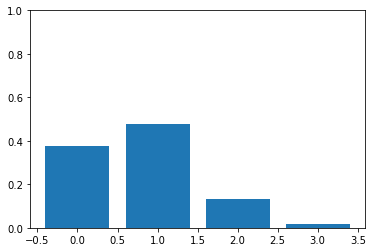

In [285]:
plt.bar(list(range(int(len(li[1])))), np.array(li[1])/sum(li[1]))
plt.ylim([0,1])

(0.0, 1.0)

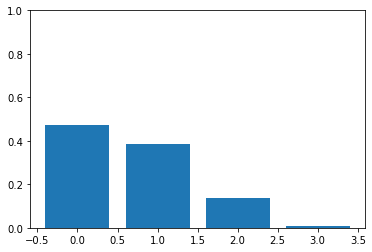

In [286]:
plt.bar(list(range(int(len(li[2])))), np.array(li[2])/sum(li[2]))
plt.ylim([0,1])

(0.0, 1.0)

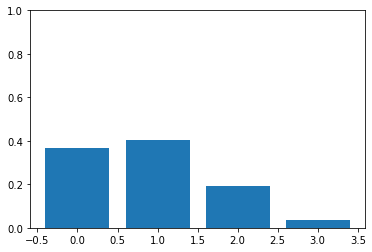

In [287]:
plt.bar(list(range(int(len(li[3])))), np.array(li[3])/sum(li[3]))
plt.ylim([0,1])

(0.0, 1.0)

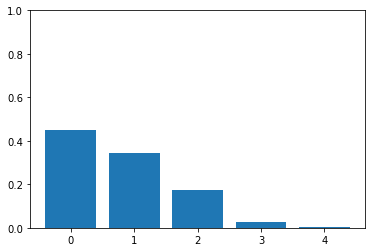

In [288]:
plt.bar(list(range(int(len(li[4])))), np.array(li[4])/sum(li[4]))
plt.ylim([0,1])

(0.0, 1.0)

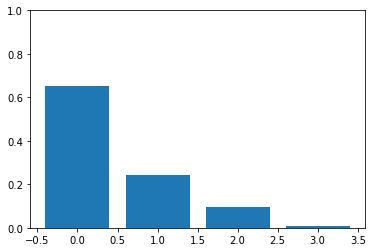

In [290]:
plt.bar(list(range(int(len(li[5])))),  np.array(li[5])/sum(li[5]))
plt.ylim([0,1])

In [ ]:
fitems = lambda x, y: map(lambda z: z[1], x)

In [48]:
def create_time_series(data, a, b, min_sessions):
    points = []
    for hour, data2 in data.groupby("hour"):
        freq = get_frequent_ar(te, get_article_list(data2), 5)
        freq = freq.loc[(freq.antecedents == a) & (freq.consequents == b)]
        if len(freq) > 0:
            points += [((hour, freq.n.values[0]))]
        else:
            points += [((hour, 0))]
        print(points[-1])
    return points

In [ ]:
ts = create_time_series(full_df, frozenset({(0, 199198)}), frozenset({(1, 272143)}), 5)

In [26]:
article = 119592

In [30]:
df2 = full_df.loc[full_df.hour == 0]

In [67]:
list(map(lambda x: map(lambda y: y[0], x), get_article_list(df2)))[0]

In [113]:
d = list(filter(lambda c: len(c) > 0, 
           map(lambda x: 
               list(filter(lambda y: 
                           y[1] == article, 
                                     x)), 
                 get_article_list(df2))))

data = list(map(lambda x: x[0][0], d))

(array([30., 33., 11.,  6.,  3.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <BarContainer object of 5 artists>)

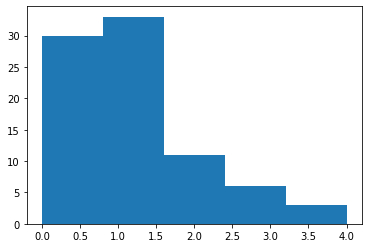

In [115]:
plt.hist(data, bins=max(data)+1)

In [141]:
del article 

In [152]:
def get_hist(df, article):
    article_pos = list(filter(lambda c: len(c) > 0, 
                   map(lambda x: 
                       list(filter(lambda y: 
                                   y[1] == article, 
                                             x)), 
                         get_article_list(df))))
    temp = []
    for item in article_pos:
        temp += item
    return list(map(lambda x: x[0], temp))

In [157]:
temp = []
for i in range(40):
    temp += [get_hist(full_df.loc[full_df.hour == i], 119592)]

In [158]:
list(map(lambda x: len(x), temp))

[83,
 228,
 127,
 78,
 59,
 78,
 213,
 372,
 473,
 329,
 353,
 311,
 256,
 173,
 170,
 139,
 117,
 121,
 129,
 136,
 144,
 113,
 123,
 63,
 52,
 25,
 0,
 1,
 0,
 0,
 2,
 2,
 1,
 2,
 2,
 2,
 0,
 1,
 1,
 0]

(array([30., 33., 11.,  6.,  3.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <BarContainer object of 5 artists>)

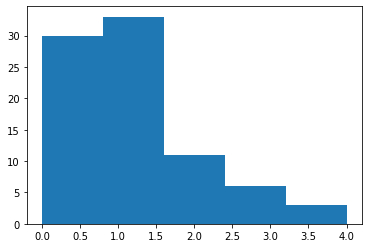

In [162]:
dd = temp[0]
plt.hist(dd, max(dd)+1)

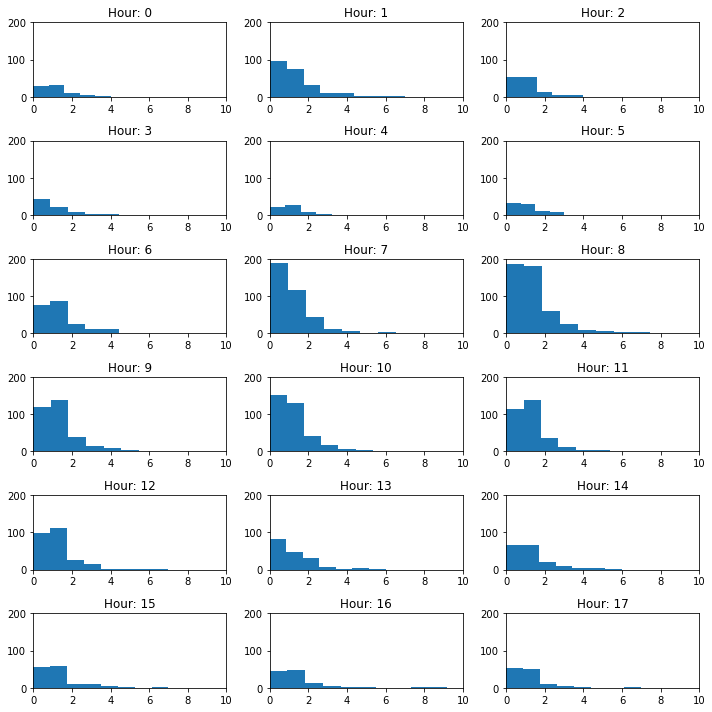

In [183]:
fig, axs = plt.subplots(6,3, figsize=(10,10))
axs = axs.flatten()

temp = []
for i in range(len(axs)):
    temp += [get_hist(full_df.loc[full_df.hour == i], 119592)]
    axs[i].hist(temp[i], bins=max(temp[i])+1)
    axs[i].set_xlim([0,10])
    axs[i].set_ylim([0,200])
    axs[i].set_title("Hour: " + str(i))
    
plt.tight_layout()